In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision import transforms
from torchvision import models


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import itertools

import PIL

import dataset_class
import torch_net_class

import functools
import operator

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Utilizing CUDA")
else:
    device = torch.device("cpu")
    print("Utilizing CPU")

Utilizing CUDA


In [3]:
"""
function for training loop
"""

def step(model, input_data, batch_size, loss_func, optimizer, epoch, batch_nr, device, log_file, mode="val"):
        if mode == "train":
            model.train()
        elif mode == "val":
            model.eval()
        
        #input data splitted into features and labels
        feat_batch = input_data[0].to(device)
        label_batch = input_data[1].to(device)
        
        input_size = model.get_input_size()
        output_size = model.get_output_size()
    
        """ALWAYS SET GRADIENT TO ZERO  FOR STANDARD NN (NOT RNNs)"""
        model.zero_grad()
        #optimizer.zero_grad()
        
        
        
        """
        the peculiar shape (-1, sample_size) is needed, because an entire mini batch is passed on to the network
        initially it is not clear how large such a mini batch is
        the -1 acts as a placeholder in order to keep the number of processed items in one mini batch flexible
        """
        #print("Input {}, batch: {} : {}".format(epoch, batch_nr, feat_batch))
        #log_file.write("Input {}, batch: {} : {}\n".format(epoch, batch_nr, feat_batch))
        
        #print("Reshaping to {}".format( feat_batch.view(-1, input_size).double().size() ))
        output = model(feat_batch.view(-1, input_size).float())
        output = output.to(device)
    
        #print("Output {}, batch: {} : {}".format(epoch, batch_nr, output))
        #print("Label {}, batch: {} : {}".format(epoch, batch_nr, label_batch))
        #log_file.write("Output {}, batch: {} : {}\n".format(epoch, batch_nr, output))
        
        #print("Input shape {}".format(feat_batch.size()))
        #print("Label shape {}".format(label_batch.size()))
        #print("Output shape {}".format(output.size()))
    
        #print("Feeding forward epoch: {}, batch: {}".format(epoch, batch_nr))
        #log_file.write("Feeding forward epoch: {}, batch: {}\n".format(epoch, batch_nr))
    
        #print("Calculating " + mode + " loss epoch: {}, batch: {}".format(epoch, batch_nr))
        #log_file.write("Calculating " + mode + " loss epoch: {}, batch: {}\n".format(epoch, batch_nr))
        """MSE"""
        #loss = loss_func(output.view(-1, output_size).float(), label_batch.view(-1, output_size).float())
        """Cross Entropy"""
        loss = loss_func(output.view(-1, output_size).float(), label_batch.view(-1).long())
        
        
        if mode == "train":
            #print("epoch: {}, batch: {}, loss: {}".format(epoch, batch_nr, loss.item()))
            #print("Performing backprop ...")
            #log_file.write("epoch: {}, batch: {}, loss: {}\n".format(epoch, batch_nr, loss.item()))
            #log_file.write("Performing backprop ...\n")
            loss.backward()
    
            #print("Adjusting weights ...")
            #log_file.write("Adjusting weights ...\n")
            optimizer.step()
    
        return loss, output



In [4]:
"""
Data preparation
"""

dataset_file_path = "ionosphere_train.csv"
test_dataset_file_path="ionosphere_test.csv"
dataset = dataset_class.dataset(dataset_file_path)
test_dataset = dataset_class.dataset(test_dataset_file_path)
#selected_pred_attributes = pd.read_csv('amazon_pred_attributes_var_corr.csv', header=None)[0].tolist()
#target_attributes = pd.read_csv('amazon_target_attribute.csv', header=None)[0].tolist()
selected_pred_attributes = [ '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33']
target_attributes = ["label"]
output_attributes = ["good", "bad"]
print(selected_pred_attributes)
print(target_attributes)
#print(list(dataset.df.columns))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33']
['label']


In [5]:
pred_attributes = selected_pred_attributes

dataset.set_pred_attributes(pred_attributes)
dataset.set_target_attribute(target_attributes)
test_dataset.set_pred_attributes(pred_attributes)
test_dataset.set_target_attribute(target_attributes)
print(pred_attributes)
print(target_attributes)
#dataset.df[pred_attributes].describe()

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33']
['label']


In [6]:
dataset.df[target_attributes].describe()

,label
count,280.000000
mean,0.650000
std,0.477824
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [7]:
dataset.df[pred_attributes].describe()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
count,280.000000,280.0,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,...,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000
mean,0.889286,0.0,0.642006,0.005401,0.613042,0.124715,0.558642,0.100720,0.514151,0.178432,...,0.401549,-0.048062,0.546989,-0.057030,0.376318,-0.047793,0.349299,0.013766,0.358110,0.006360
std,0.314340,0.0,0.507474,0.444380,0.520414,0.455321,0.493897,0.514517,0.522983,0.485672,...,0.584663,0.501739,0.530014,0.554377,0.590581,0.503374,0.591181,0.513241,0.528868,0.455715
min,0.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,0.0,0.473603,-0.082590,0.435122,-0.023300,0.256398,-0.054445,0.137793,-0.044605,...,0.000000,-0.279763,0.332323,-0.336245,0.000000,-0.240383,0.000000,-0.234442,0.000000,-0.188065
50%,1.000000,0.0,0.880940,0.007075,0.833680,0.023915,0.748205,0.011710,0.692890,0.023530,...,0.559255,-0.008660,0.723380,-0.014165,0.507815,0.000000,0.451060,0.000000,0.432665,0.000000
75%,1.000000,0.0,1.000000,0.156713,1.000000,0.338090,0.968035,0.364705,0.956382,0.541510,...,0.916347,0.160588,1.000000,0.162285,0.904700,0.129445,0.880257,0.214865,0.839647,0.155463
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
"""Data scaling"""

#dataset.min_max_scaling(attributes=pred_attributes)
#dataset.z_score_standardization(attributes=pred_attributes)
#test_dataset.z_score_standardization(attributes=pred_attributes)
#dataset.z_score_standardization(attributes=pred_attributes[3:])
#dataset.min_max_scaling(attributes=target_attributes)
#scaling_func=lambda x: x/9.
#inv_scaling_func = lambda x: 9.*x
#dataset.custom_scaling(attributes=target_attributes, scaling_func=scaling_func)

'Data scaling'

In [9]:
#dataset.df[pred_attributes].describe()

In [10]:
#dataset.df[target_attributes].head()

In [11]:
"""
HYPERPARAMETERS
"""

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

"""
Some possible model parameters:
parameter_options = {}
parameter_options["act_func"] = [torch.relu, torch.sigmoid, , torch.tanh]
parameter_options["loss_func"] = [torch.sigmoid, torch.relu, torch.tanh]
parameter_options["dropout"] = [nn.Dropout, None]
parameter_options["optimizer"] = [optim.Adam, optim.SGD]
parameter_options["val"] = ["kfold", "holdout"]
parameter_options["task"] = ["classification", "regression"] 
"""

"""the parameter options dictionary records which hyperparameters to use"""
parameter_options = {}
"""
parameter_options["task"] = ["classification"] 

parameter_options["val"] = ["holdout"]
parameter_options["split"] = [0.7]
#parameter_options["val"] = ["kfold"]
#parameter_options["k_fold"] = [10]

parameter_options["batch_size"] = [1]
parameter_options["lr"] = [0.001]

parameter_options["hidden_layers"] = [3]
parameter_options["layer_width"] = [9]
parameter_options["bias"] = [True]
parameter_options["act_func"] = [torch.relu]

#parameter_options["loss_func"] = [nn.MSELoss]
parameter_options["loss_func"] = [nn.CrossEntropyLoss]
parameter_options["optimizer"] = [optim.Adam]

parameter_options["dropout"] = [None]
parameter_options["p_dropout"] = [0.1]

"""

"""
Create cartesian product of all possible parameter combinations
"""
"""
def cart_product(dict_options):
    return ( dict(zip(dict_options.keys(), values)) for values in itertools.product(*dict_options.values()) )

parameter_selector = cart_product(parameter_options)
"""


"""Manually set network structure"""
"""
    This list can be loaded into the constructor of the Net neural network class, to automatically generate the network structure
    type = pointer to the layer function'
    layer_pars = parameters which must be given to the layer function in order to initialize it
    act_func = activation function to be applied directly after feeding to the corresponding layer
    dropout = certain neurons cna be dropped out if specified
"""

fixed_net_struct = []
layer = nn.Linear
act_func = torch.relu
dropout = nn.Dropout
#dropout = None
p = 0.2
bias = True
input_size = len(pred_attributes)
target_size = len(target_attributes)
output_size = len(output_attributes)
fixed_net_struct.append( {"type": layer, "layer_pars": {"in_features": input_size, "out_features": 20}, "act_func": act_func, "bias": bias} )
if dropout is not None:    
    fixed_net_struct.append( {"type": dropout, "layer_pars": {"p": p }} )
fixed_net_struct.append( {"type": layer, "layer_pars": {"in_features": 20, "out_features": 20}, "act_func": act_func, "bias": bias} )
fixed_net_struct.append( {"type": layer, "layer_pars": {"in_features": 20, "out_features": output_size}, "bias": bias} )

"""If required create list of parameters manually"""

parameter_selector = []

parameter_option = {"batch_size":16,"lr":0.0001,"loss_func":nn.CrossEntropyLoss,"optimizer":optim.Adam}

parameter_option["task"] = "classification"

parameter_option["val"] = "holdout"
parameter_option["split_ratio"] = {"train" : 0.7, "val" : 0.3, "test" : 0.0}

#parameter_option["val"] = "kfold"
#parameter_option["ksplits"] = 4

parameter_option["hidden_layers"] = 3
parameter_option["layer_width"] = 10
parameter_option["act_func"] = torch.relu
parameter_option["net_struct"] = fixed_net_struct
parameter_selector.append(parameter_option)

"Set the number of epochs (max(val_epochs) and at which epochs model shall be validated)"
val_epochs = [16, 32, 48, 64, 86, 100]
#val_epochs = [16, 32, 48]
#val_epochs = [5]
save_state_epochs = [100]


In [12]:
"""
MAYBE AN ADDITIONAL TRAIN TEST SPLIT IS NECESSARY HERE
NEXT CELL = TRAIN + VAL
AFTER PLOTTING CONF MAT -> TESTING
For splitting add line:
remaining_indices, test_indices = train_test_split(all_indices, test_size=test_size, shuffle=True, random_state=random_seed)

Loading this separate test split for evaluation then either required loading test_indices:
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)


The Code which splits train and val is written as (see below):
all_indices = remaining_indices
indices[0], indices[1] = train_test_split(all_indices, test_size=split_ratio["val"], shuffle=True, random_state=random_seed)


"""

"""
all_indices = list(range(dataset.get_length()))
remaining_indices, test_indices = train_test_split(all_indices, test_size=parameter_option["split"]["test"], shuffle=True, random_state=random_seed)

print("size of test set :{}".format(int(parameter_option["split"]["test"]*dataset.get_length())))
print("size of train set :{}".format(int(parameter_option["split"]["train"]*dataset.get_length())))
print("one batch with size:{}".format(int(parameter_option["split"]["train"]*dataset.get_length())%parameter_option["batch_size"]))
"""

'\nMAYBE AN ADDITIONAL TRAIN TEST SPLIT IS NECESSARY HERE\nNEXT CELL = TRAIN + VAL\nAFTER PLOTTING CONF MAT -> TESTING\nFor splitting add line:\nremaining_indices, test_indices = train_test_split(all_indices, test_size=test_size, shuffle=True, random_state=random_seed)\n\nLoading this separate test split for evaluation then either required loading test_indices:\ntest_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)\ntest_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)\n\n\nThe Code which splits train and val is written as (see below):\nall_indices = remaining_indices\nindices[0], indices[1] = train_test_split(all_indices, test_size=split_ratio["val"], shuffle=True, random_state=random_seed)\n\n\n'

In [13]:
"""
All errors from each validation epoch will be saved
this list contains them
Saving them in memory is not always viable, which is why they are also saved on the hard drive
"""
#first index is parameter run
#second is fold
#third is epoch
model_errors = []
"""
All errors from each validation epoch will be saved as a file
this list contains the path to these files
"""
#first index is parameter run
#second is fold
#third is epoch
#fourth is prediction or label 
model_errors_path_list = []

"""
The average training loss for each epoch is recorded here
"""
#first index is parameter run
#second is fold
loss_curves = []
loss_path_list = []

"""
States of the neural network are saved as a file
filename is part of this list
"""
#first index is parameter run
#second is fold
#third is epoch
saved_states_file_path_list = []

"""Perform training for each parameter option in parameter_selector"""
par_i = 0
for hyper_parameters in parameter_selector:
    
    epochs = max(val_epochs)
    input_size = len(pred_attributes)
    target_size = len(target_attributes)
    output_size = len(output_attributes)
    
    lr=hyper_parameters["lr"]
    batch_size = hyper_parameters["batch_size"]
    
    loss_func = hyper_parameters["loss_func"]()
    
    
    """
    If a network structure is fixed beforehand, construct this
    Otherwise create a "rectangular" fully connected feedforward network, with a fixed number of hidden layers and neurons per layer
    """
    net_struct = []
    if "net_struct" in hyper_parameters.keys():
        net_struct = hyper_parameters["net_struct"]
    else:
        layer = nn.Linear
        act_func = hyper_parameters["act_func"]
        dropout = hyper_parameters["dropout"]
        p = hyper_parameters["p_dropout"]
        bias = hyper_parameters["bias"]
        lw = hyper_parameters["layer_width"]
        hl = hyper_parameters["hidden_layers"]
    
        net_struct.append( {"type": layer, "layer_pars": {"in_features": input_size, "out_features": lw}, "act_func": act_func, "bias": bias} )
        if dropout is not None:    
            net_struct.append( {"type": dropout, "layer_pars": {"p": p }} )
        if hl > 1:
            for num_layer in range(hl-1):
                    net_struct.append( {"type": layer, "layer_pars": {"in_features": lw, "out_features": lw}, "act_func": act_func, "bias": bias} )
        net_struct.append( {"type": layer, "layer_pars": {"in_features": lw, "out_features": output_size}, "bias": bias} )
    
    """Choose between holdout validation and k-fold cross validation"""
    if hyper_parameters["val"] == "holdout":
        """DEPENDING ON TRAIN+VAL+TEST SPLIT ADAPT all_indices"""
        all_indices = list(range(dataset.get_length()))
        #all_indices = remaining_indices
        indices = [None, None]
        split_ratio = hyper_parameters["split_ratio"]
        indices[0], indices[1] = train_test_split(all_indices, test_size=split_ratio["val"], shuffle=True, random_state=random_seed)
        indices = [indices]
    elif hyper_parameters["val"] == "kfold":
        """NOT WORKING ATM"""
        k_splits = hyper_parameters["ksplits"]
        kf = KFold(n_splits=k_splits, shuffle=True, random_state=random_seed)
        indices = kf.split(dataset.df)
    
    """
    Training
    """
    par_dir = str("par_{}".format(par_i))
    
    fold_model_errors = []
    fold_model_errors_path_list = []
    fold_saved_states_path_list = []
    par_loss_curves = []
    n_split = 0
    for fold_indices in indices:
        
        train_indices = fold_indices[0]
        val_indices = fold_indices[1]
        
        fold_loss_curve = []
        print("fold {}".format(n_split))
        fold_dir = par_dir + "/" + "fold_{}".format(str(n_split))
        try:
            os.makedirs(fold_dir)
        except FileExistsError:
            pass

        net = torch_net_class.Net(net_struct, input_size)
        net.init_weights(torch.nn.init.xavier_normal_)
        net.set_batch_size(batch_size)
        #net.cuda()
        net.to(device)
        
        net_parameters = net.parameters()
        optimizer = hyper_parameters["optimizer"](net_parameters, lr=lr)
        
        #create training log
        train_log_file_name = fold_dir +"/train_log.txt"
        train_log_file = open(train_log_file_name, "w")
        train_log_file.write( "Training log fold {} :\n".format(str(n_split)) )
        net.show_layers()
        train_log_file.write(str(net.get_net_struct()))

        """split training in train and val and load data"""
        train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
        val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
        #test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
        #val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=val_sampler)
        #test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)


        train_state_dir = fold_dir + "/net_states"
        try:
            os.makedirs(train_state_dir)
        except FileExistsError:
            pass

        train_loss_curve = []
        val_loss_curve = []
        
        fold_epoch_model_errors = []
        fold_epoch_model_errors_path_list = []
        fold_epoch_saved_states_path_list = []
        for epoch in range(0, epochs):
            
            batch_nr = 0
            epoch_loss = 0.

            """Actual training step"""
            for train_mini_batch in train_loader:
                batch_nr += 1
                batch_loss, train_output = step(net, train_mini_batch, batch_size, loss_func, optimizer, epoch, batch_nr, device, train_log_file, mode="train")
                epoch_loss += batch_loss.item()
            
            """Averaging training loss"""
            epoch_loss = epoch_loss/len(train_loader)
            train_loss_curve.append(epoch_loss)
            fold_loss_curve.append(epoch_loss)

            print("mean epoch loss: {}".format(epoch_loss))
            train_log_file.write("mean epoch loss: {}\n".format(epoch_loss))

            epoch_val_loss = 0

            if (epoch+1) in save_state_epochs or epoch == epochs:
                train_state_epoch_file_name = "state_epoch_{}".format(epoch)
                train_state = {"epoch" : epoch, "state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
                torch.save(train_state, train_state_dir + "/" + train_state_epoch_file_name )
                fold_epoch_saved_states_path_list.append(train_state_dir + "/" + train_state_epoch_file_name)
                print("saved model from epoch {}".format(epoch))
                train_log_file.write("saved model from epoch {}\n".format(epoch))
        
            """
            Valdation
            """
            #validate for each epoch reached in val_epochs
            if (epoch+1) in val_epochs:
            #if (epoch) in val_epochs:

                val_loss = []
                val_pred = []
                val_label = []
                val_i = 0
                for val_mini_batch in val_loader:

                    feat_batch = val_mini_batch[0]
                    label_batch = val_mini_batch[1]
                    val_label.append(label_batch.numpy())
                    
                    val_batch_loss, val_output = step(net, val_mini_batch, batch_size, loss_func, optimizer, epoch, batch_nr, device, train_log_file, mode="val")
                    
                    if hyper_parameters["task"] == "classification":
                        """for a classification task"""
                        class_batch_pred = []
                        for output_val in val_output:
                            class_index = output_val.argmax().detach().cpu()
                            class_batch_pred.append(class_index)
                            #print(output_val)
                            #print(class_index)
                        val_pred.append(class_batch_pred)
                        #print(val_pred)
                    elif hyper_parameters["task"] == "regression":
                        """for a regression task"""
                        val_pred.append(val_output.detach().cpu().numpy())
                    

                    val_loss.append(val_batch_loss.item())
                    #print(val_batch_loss.item())
                    val_i += 1
                
                
                val_pred_df = pd.DataFrame(np.concatenate(np.asarray(val_pred)))
                #print(np.concatenate(np.asarray(val_pred)))
                val_label_df = pd.DataFrame(np.concatenate(np.asarray(val_label)), )
                
                
                """
                if type(inv_scaling_func) is not None:
                    scaled_val_pred_df = inv_scaling_func(val_pred_df.copy())
                    scaled_val_label_df = inv_scaling_func(val_label_df.copy())
                    dev_df = scaled_val_label_df - scaled_val_pred_df
                """
                
                val_error_df = pd.DataFrame()
                
                val_error_df["train_label"] = val_label_df[0]
                val_error_df["train_prediction"] = val_pred_df[0]
                
                
                fold_epoch_model_errors.append(val_error_df.copy())
                fold_epoch_model_pred_path = fold_dir + "/" +"val_epoch_{}_pred".format(epoch)
                fold_epoch_model_labels_path = fold_dir + "/" +"val_epoch_{}_labels".format(epoch)
                val_pred_df.to_pickle(fold_epoch_model_pred_path)
                val_label_df.to_pickle(fold_epoch_model_labels_path)
                fold_epoch_model_errors_path_list.append([fold_epoch_model_pred_path, fold_epoch_model_labels_path])
        
        """fold_model_errors.append(fold_epoch_model_errors.copy())"""
        fold_model_errors_path_list.append(fold_epoch_model_errors_path_list)
        fold_saved_states_path_list.append(fold_epoch_saved_states_path_list)
        par_loss_curves.append(fold_loss_curve)
        
        n_split += 1
        
        #del net
        #del optimizer
        
    """model_errors.append(fold_model_errors.copy())"""
    model_errors_path_list.append(fold_model_errors_path_list)
    saved_states_file_path_list.append(fold_saved_states_path_list)
    loss_curves.append(par_loss_curves)
    
    """Plot training loss curve and save as image"""
    train_loss_img_file_name = par_dir + "/" + "train_loss_par_" + str(par_i) + ".png"
    x_epochs = range(epochs)
    for fold_i in range(len(loss_curves[par_i])):
        plt.plot(x_epochs, loss_curves[par_i][fold_i])
    #plt.title()
    plt.xlabel("epoch")
    plt.ylabel("training loss")
    plt.savefig(train_loss_img_file_name)
    plt.close()
    train_loss_txt_file_name = par_dir + "/" + "train_loss_par_" + str(par_i) + ".txt"
    np.savetxt(train_loss_txt_file_name, loss_curves[par_i])
    
    par_i += 1
    
    train_log_file.close()

fold 0
Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 34, 'out_features': 20}, 'act_func': <built-in method relu of type object at 0x7ff2b2cb6be0>, 'bias': True}

Adding {'type': <class 'torch.nn.modules.dropout.Dropout'>, 'layer_pars': {'p': 0.2}}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 20, 'out_features': 20}, 'act_func': <built-in method relu of type object at 0x7ff2b2cb6be0>, 'bias': True}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 20, 'out_features': 2}, 'bias': True}

Linear(in_features=34, out_features=20, bias=True)
Dropout(p=0.2, inplace=False)
Linear(in_features=20, out_features=20, bias=True)
Linear(in_features=20, out_features=2, bias=True)
mean epoch loss: 0.7622593962229215
mean epoch loss: 0.7420881298872141
mean epoch loss: 0.7445767109210675
mean epoch loss: 0.7143227687248817
mean epoch loss: 0.6827638607758743
mean epoch loss: 0.6760

In [14]:
"""
parameter_selector = cart_product(parameter_options)
parameter_selector_list = []
par_list_file = open("par_list.txt","w")
i=0
for cart in parameter_selector:
    #print(cart)
    par_list_file.write(str(i) + "\n")
    par_list_file.write(str(cart) + "\n")
    parameter_selector_list.append(cart)
    i += 1
print(len(parameter_selector_list))
par_list_file.close()
"""

'\nparameter_selector = cart_product(parameter_options)\nparameter_selector_list = []\npar_list_file = open("par_list.txt","w")\ni=0\nfor cart in parameter_selector:\n    #print(cart)\n    par_list_file.write(str(i) + "\n")\n    par_list_file.write(str(cart) + "\n")\n    parameter_selector_list.append(cart)\n    i += 1\nprint(len(parameter_selector_list))\npar_list_file.close()\n'

In [15]:
#first index is parameter run
#second is fold
#third is epoch
#model_errors[0][0][0].describe()

In [16]:
#first index is parameter run
#second is fold
#third is epoch
#fourth is prediction or label
test_pickle_pred_df = pd.read_pickle(model_errors_path_list[0][0][-1][0])
test_pickle_label_df = pd.read_pickle(model_errors_path_list[0][0][-1][1])
test_pickle_label_df.columns = ["train_label"]
test_pickle_pred_classes = test_pickle_pred_df.max(axis=1)
test_pickle_pred_df["train_prediction"] = pd.DataFrame(test_pickle_pred_classes)
test_pickle_errors_df = pd.DataFrame()
test_pickle_errors_df["train_prediction"] = test_pickle_pred_df["train_prediction"]
test_pickle_errors_df["train_label"] = test_pickle_label_df["train_label"]

test_pickle_errors_df.head(10)

,train_prediction,train_label
0,1,0.0
1,1,1.0
2,1,1.0
3,1,1.0
4,0,0.0
5,1,1.0
6,0,0.0
7,1,1.0
8,1,1.0
9,0,0.0


In [17]:
"""
For classification
plot the confusion matrix to evaluate model
"""

#label_dict = {}
#for i in range(len(dataset.label_encoder.classes_)):
#    label_dict[i] = dataset.label_encoder.classes_[i]

#test_pickle_errors_df_copy = test_pickle_errors_df.query("train_prediction != 3")
test_pickle_errors_df_copy = test_pickle_errors_df.copy()
sk_conf_mat = confusion_matrix(test_pickle_errors_df_copy["train_label"], test_pickle_errors_df_copy["train_prediction"])
print(sk_conf_mat)

[[17 14]
 [ 1 52]]


In [18]:
#print(sk_conf_mat)
norm_conf_mat = sk_conf_mat.astype(float)
#print(norm_conf_mat)

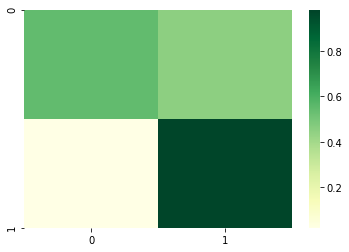

In [19]:
for i,line in enumerate(norm_conf_mat[:,]):
    #print(i)
    #print(line)
    #print(norm_conf_mat[i].sum())
    norm_conf_mat[i] = norm_conf_mat[i]/(norm_conf_mat[i].sum())
    
#print(norm_conf_mat)
sns.heatmap(norm_conf_mat,cmap="YlGn",annot=False)

In [20]:
np_label = np.array(test_pickle_errors_df["train_label"])
np_pred = np.array(test_pickle_errors_df["train_prediction"])

In [21]:
acc = sklearn.metrics.accuracy_score(np_label, np_pred)
rec = sklearn.metrics.recall_score(np_label, np_pred, average=None)
prec = sklearn.metrics.precision_score(np_label, np_pred, average=None)

print("Accuracy:\n {}".format(acc))

print("Recall:\n {}".format(rec))
print("averaged recall: {} +- {}".format(rec.mean(), rec.std()) )

print("Precision:\n {}".format(prec))
print("averaged precision: {} +- {}".format(prec.mean(), prec.std()) )

Accuracy:
 0.8214285714285714
Recall:
 [0.5483871  0.98113208]
averaged recall: 0.7647595861229458 +- 0.2163724893487523
Precision:
 [0.94444444 0.78787879]
averaged precision: 0.8661616161616161 +- 0.07828282828282829


In [22]:
"""
Testing
"""
"""
Load the test data (depending in your need)
by loading the indices (mentioned above)
or creating new instance of dataset class
"""
#test_dataset = dataset_class.dataset()

'\nLoad the test data (depending in your need)\nby loading the indices (mentioned above)\nor creating new instance of dataset class\n'

In [23]:
#test model with test dataset

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=)

test_pred = []
test_label = []
epoch = 0
batch_nr = 0
for test_mini_batch in test_loader:
    batch_nr += 1
    feat_batch = test_mini_batch[0]
    label_batch = test_mini_batch[1]
    test_label.append(label_batch.detach().cpu().numpy())
    test_batch_loss, test_output = step(net, test_mini_batch, batch_size, loss_func, optimizer, epoch, batch_nr, device, train_log_file, mode="test")

    if hyper_parameters["task"] == "classification":
        """for a classification task"""
        class_batch_pred = []
        for test in test_output:
            class_index = test.argmax().detach().cpu()
            class_batch_pred.append(class_index)
        test_pred.append(class_batch_pred)
    elif hyper_parameters["task"] == "regression":
        """for a regression task"""
        test_pred.append(test_output.detach().cpu().numpy())


"""SAVE NUMPY ARRAY INSTEAD OF DF"""
#test_pred_df = pd.DataFrame(np.hstack(test_pred))
#test_label_df = pd.DataFrame(np.hstack(test_label))

test_pred_df = pd.DataFrame(functools.reduce(operator.iconcat, test_pred, []))
test_label_df = pd.DataFrame(functools.reduce(operator.iconcat, test_label, []))


test_error_df = pd.DataFrame()

test_error_df["train_label"] = test_label_df[0]
test_error_df["train_prediction"] = test_pred_df[0]

SyntaxError: invalid syntax (<ipython-input-23-a56fb8fe10ea>, line 3)

In [ ]:
sk_conf_mat = confusion_matrix(test_error_df["train_label"], test_error_df["train_prediction"])
#print(sk_conf_mat)

In [ ]:
norm_conf_mat = sk_conf_mat.astype(float)
#print(norm_conf_mat)

In [ ]:
for i,line in enumerate(norm_conf_mat[:,]):
    #print(i)
    #print(line)
    #print(norm_conf_mat[i].sum())
    norm_conf_mat[i] = norm_conf_mat[i]/(norm_conf_mat[i].sum())
    
#print(norm_conf_mat)
sns.heatmap(norm_conf_mat,cmap="YlGn",annot=False)

In [ ]:
np_label = np.array(test_pickle_errors_df["train_label"])
np_pred = np.array(test_pickle_errors_df["train_prediction"])

acc = sklearn.metrics.accuracy_score(np_label, np_pred)
rec = sklearn.metrics.recall_score(np_label, np_pred, average=None)
prec = sklearn.metrics.precision_score(np_label, np_pred, average=None)

print("Accuracy:\n {}".format(acc))

print("Recall:\n {}".format(rec))
print("averaged recall: {} +- {}".format(rec.mean(), rec.std()) )

print("Precision:\n {}".format(prec))
print("averaged precision: {} +- {}".format(prec.mean(), prec.std()) )

print("\n")

In [ ]:
print(dataset.label_encoder.classes_)